In [1]:
import os
import glob
import pandas as pd
import numpy as np
import torch
import json
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import random
import numpy as np 
import pandas as pd 
from glob import glob 
import matplotlib.pyplot as plt


from src.data.utils import read_rgb

In [413]:
import albumentations as albu
from albumentations.pytorch.transforms import ToTensorV2


def get_train_transforms(target_img_size=512):
    return albu.Compose(
        [
            albu.HorizontalFlip(p=0.5),
            albu.Resize(height=target_img_size, width=target_img_size, p=1),
            albu.Normalize(),
            ToTensorV2(p=1),
        ],
        p=1.0,
        bbox_params=albu.BboxParams(
            format="pascal_voc", min_visibility=0, min_area=0, label_fields=["labels"]
        ),
    )

def get_val_transforms(img_size=512):
    return albu.Compose(
        [
            albu.Resize(height=img_size, width=img_size, p=1),
            #albu.Normalize(),
            ToTensorV2(p=1),
        ],
        p=1.0,
        bbox_params=albu.BboxParams(
            format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )


In [414]:
class XrayDataset(Dataset):
    def __init__(self, root, annotations_file, transforms=None):
        self.root = root
        self.transforms = transforms
        self.annotations_df = pd.read_csv(annotations_file, index_col=[0])

    def __len__(self):
        return len(self.annotations_df)

    def __getitem__(self, idx):
        row = self.annotations_df.iloc[idx]
        image_id = row['Image Index']
        img_path = os.path.join(self.root, image_id)
        image = read_rgb(img_path)
        # to pascal vos format
        box = [
            row['x'],
            row['y'],
            row['x'] + row['w'],
            row['y'] + row['h'],
        ]
        
        label = row['label']
        box = np.array(box)

        if self.transforms:
            transformed = self.transforms(image=image, bboxes=[box], labels=[label])
            image = transformed['image']
            _, img_h, img_w = image.shape
            bboxes = transformed['bboxes']
            labels = transformed['labels']
            target = {
                'bbox': torch.as_tensor(bboxes, dtype=torch.float32),
                'cls': torch.as_tensor(labels, dtype=torch.float32),
                'img_size': torch.tensor([img_h, img_w]),
                'img_scale': torch.tensor([1.0]),
            }

        return image / 255. , target
    



    @staticmethod
    def collate_fn(batch):
        images, targets = tuple(zip(*batch))
        images = torch.stack(images)
        images = images.float()

        boxes = [target["bbox"].float() for target in targets]
        labels = [target["cls"].float() for target in targets]

        annotations = {
            "bbox": boxes,
            "cls": labels,
        }

        return images, annotations, targets, image_ids
    
    

def alex_fn(batch):
    return tuple(zip(*batch))


In [723]:
image_folder_path = "/data1/xray_data/images"
annotations_file = 'dataset/val_df.csv'
train_dataset = XrayDataset(image_folder_path, annotations_file, transforms=get_val_transforms())
trainloader = DataLoader(train_dataset, batch_size = 1)#, collate_fn=alex_fn)

In [416]:
train_dataset[0][0].shape

torch.Size([3, 512, 512])

In [417]:
image = train_dataset[0][0]
x, y, max_x, max_y = train_dataset[0][1]['bbox'][0]
cv2.rectangle(image, (int(x), int(y)), (int(max_x), int(max_y)), (255, 0, 0), 2)
plt.imshow(image)

error: OpenCV(4.8.1) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - img is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'img'
>  - img is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'img'


In [653]:
from effdet.config.model_config import efficientdet_model_param_dict
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, DetBenchPredict
from effdet.efficientdet import HeadNet
from effdet.config.model_config import efficientdet_model_param_dict


def create_model(num_classes=7,image_size=512, architecture="tf_efficientdet_lite3"):
    efficientdet_model_param_dict['tf_efficientnetv2_l'] = dict(
        name='efficientnet_b0',
        backbone_name='efficientnet_b0',
        backbone_args=dict(drop_path_rate=0.2),
        num_classes=num_classes,
        url='', )
    
    config = get_efficientdet_config(architecture)
    config.update({'num_classes': num_classes})
    config.update({'image_size': (image_size, image_size)})

    net = EfficientDet(config, pretrained_backbone=True)
    net.class_net = HeadNet(
        config,
        num_outputs=config.num_classes,
    )
    return net, config




In [654]:
net, config = create_model()
model = DetBenchPredict(net)

In [794]:
from collections import OrderedDict

device = "cuda" if torch.cuda.is_available() else "cpu"    
#sd = torch.load("/srv/checkpoints/xray/2024-06-13 20:37:10/best.ckpt")['state_dict'] 
#sd = torch.load("/srv/checkpoints/xray/2024-06-14 09:49:10/best.ckpt")['state_dict'] 
sd = torch.load("/srv/checkpoints/xray/2024-06-14 16:17:09/best.ckpt")['state_dict'] 


new_sd = OrderedDict()
for k, v in sd.items():
    new_sd[k[8:]] = v
    

model.load_state_dict(new_sd, strict=True)
model.eval();

In [293]:
model.forward??

Signature: model.forward(x, img_info: Optional[Dict[str, torch.Tensor]] = None)
Docstring:
Defines the computation performed at every call.

Should be overridden by all subclasses.

.. note::
    Although the recipe for forward pass needs to be defined within
    this function, one should call the :class:`Module` instance afterwards
    instead of this since the former takes care of running the
    registered hooks while the latter silently ignores them.
Source:   
    def forward(self, x, img_info: Optional[Dict[str, torch.Tensor]] = None):
        class_out, box_out = self.model(x)
        class_out, box_out, indices, classes = _post_process(
            class_out,
            box_out,
            num_levels=self.num_levels,
            num_classes=self.num_classes,
            max_detection_points=self.max_detection_points,
        )
        if img_info is None:
            img_scale, img_size = None, None
        else:
            img_scale, img_size = img_info['img_scale'], img_in

In [57]:
result = model(img, annot)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [473]:
model = model.to(device)

In [231]:
output = next(iter(trainloader))
img, annot = output[0], output[1]

In [795]:
from ensemble_boxes import ensemble_boxes_wbf, weighted_boxes_fusion
from torchmetrics.classification import BinaryConfusionMatrix
from torchmetrics.detection.mean_ap import MeanAveragePrecision


def make_predictions(images, score_threshold=0.05):
    #images = torch.stack(images).cuda().float()
    map_metric = MeanAveragePrecision()
    confusion_matrix = BinaryConfusionMatrix()
    predictions = []
    with torch.no_grad():
        model.eval()
        
        outputs = model(images.float().cuda())
        for i in range(images.shape[0]):
            #boxes = det[i]['boxes'].detach().cpu().numpy()
            #scores = det[i]['scores'].detach().cpu().numpy()
            #labels = det[i]['labels'].detach().cpu().numpy()
            #print(det)
            boxes = outputs[i].detach().cpu().numpy()[:,:4]    
            scores = outputs[i].detach().cpu().numpy()[:,4]
            labels = outputs[i].detach().cpu().numpy()[:, 5]
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
                'labels': labels[indexes],
            })
    return [predictions]

def run_wbf(predictions, image_index, image_size=512, iou_thr=0.2, skip_box_thr=0.1, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist()  for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist()  for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).tolist() for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels




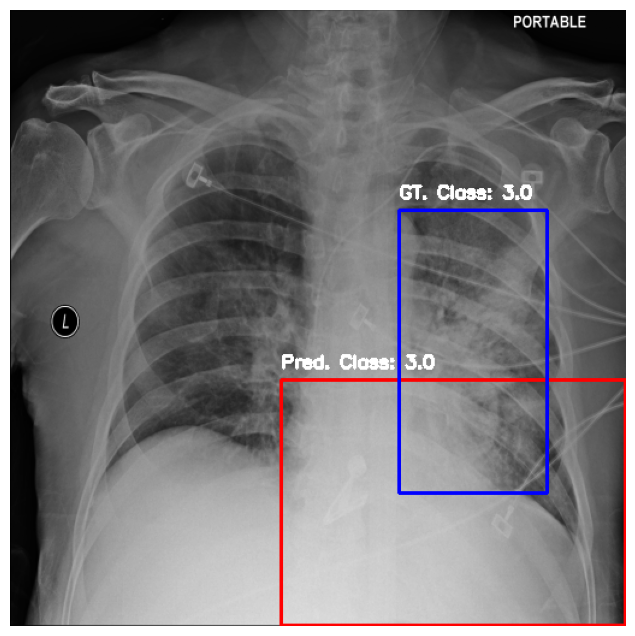

In [833]:

output = train_dataset[63]
img, annot = output[0].unsqueeze(0), output[1]
model = model.to(device)
true_box = annot['bbox'].cpu().numpy()[0]
true_box = true_box.astype(np.int32).clip(min=0, max=511)
true_label = annot['cls'].cpu().numpy()[0]

predictions = make_predictions(img )

i = 0
sample = img[i].permute(1,2,0).cpu().numpy()
#boxes, scores, labels = run_wbf(predictions, image_index=i)
boxes = predictions[0][0]['boxes'][0]
boxes = boxes.astype(np.int32).clip(min=0, max=511)
#true_label = 5.0
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
labels = predictions[0][0]['labels']
box = boxes
cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
cv2.putText(sample, f'Pred. Class: {labels[0]}', (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36,255,12), 2)
try:
    cv2.rectangle(sample, (true_box[0], true_box[1]), (true_box[2], true_box[3]), (0, 0, 255), 2) 
    cv2.putText(sample, f'GT. Class: {true_label}', (true_box[0], true_box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36,255,12), 2)
except:
    pass
ax.set_axis_off()
ax.imshow(sample);

In [784]:
def make_predictions(dataloader, score_threshold=0.05):
    #images = torch.stack(images).cuda().float()
    map_metric = MeanAveragePrecision()
    confusion_matrix = BinaryConfusionMatrix()
    predictions = []
    with torch.no_grad():
        model.eval()
        
        for image, targets in dataloader:
            #images = torch.stack(image).cuda().float()
            outputs = model(image.float().cuda())
            for i in range(image.shape[0]):
                #boxes = det[i]['boxes'].detach().cpu().numpy()
                #scores = det[i]['scores'].detach().cpu().numpy()
                #labels = det[i]['labels'].detach().cpu().numpy()
                #print(det)
                boxes = outputs[i].detach().cpu().numpy()[:,:4]    
                scores = outputs[i].detach().cpu().numpy()[:,4]
                labels = outputs[i].detach().cpu().numpy()[:, 5]
                indexes = np.where(scores > score_threshold)[0]
                max_index = np.argmax(scores)
                boxes = boxes[max_index].reshape(1, -1)
                scores = scores[max_index].reshape(1, -1)
                labels = labels[max_index].reshape(1, -1)

                boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] + boxes[:, 1]

                predictions.append({
                    'boxes': boxes,
                    'scores': scores,
                    'labels': labels,
                })
                # Update metrics
                pred = {'boxes': torch.tensor(boxes), 'scores': torch.tensor(scores), 'labels': torch.tensor(labels,dtype=torch.int64)}
                target = {'boxes': targets['bbox'], 'labels': torch.as_tensor(targets['cls'])}

                preds_bin = (scores > 0.3).astype(int)
                targets_bin = (targets['cls'].numpy() > 0).astype(int)
                confusion_matrix.update(torch.tensor(preds_bin), torch.tensor(targets_bin))
            # Compute metrics
        conf_matrix = confusion_matrix.compute()
        tn, fp, fn, tp = conf_matrix.flatten()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        print(f"Sensitivity: {sensitivity}")
        print(f"Specificity: {specificity}")

    return [predictions]

In [785]:
make_predictions(trainloader);

Sensitivity: 0.35537189245224
Specificity: 0.7037037014961243


In [314]:
box[0]

array([ 63.932274, 288.23703 , 216.17778 , 358.1291  ], dtype=float32)

In [ ]:
preds_df = ensemble_predictions(test_loader)

In [30]:
from ensemble_boxes import ensemble_boxes_wbf
img_size = 512
wbf_iou_threshold=0.44
prediction_confidence_threshold=0.2
device = "cuda:5" if torch.cuda.is_available() else "cpu"


def predict(images_tensor: torch.Tensor):
    """
    For making predictions from tensors returned from the model's dataloader
    Args:
        images_tensor: the images tensor returned from the dataloader

    Returns: a tuple of lists containing bboxes, predicted_class_labels, predicted_class_confidences

    """
    if images_tensor.ndim == 3:
        images_tensor = images_tensor.unsqueeze(0)
    if (
        images_tensor.shape[-1] != img_size
        or images_tensor.shape[-2] != img_size
    ):
        raise ValueError(
            f"Input tensors must be of shape (N, 3, {img_size}, {img_size})"
        )

    num_images = images_tensor.shape[0]
    image_sizes = [(img_size, img_size)] * num_images

    return _run_inference(images_tensor, image_sizes)


def run_wbf(predictions, image_size=512, iou_thr=0.44, skip_box_thr=0.43, weights=None):
    bboxes = []
    confidences = []
    class_labels = []

    for prediction in predictions:
        boxes = [(prediction["boxes"] / image_size).tolist()]
        scores = [prediction["scores"].tolist()]
        labels = [prediction["classes"].tolist()]

        boxes, scores, labels = ensemble_boxes_wbf.weighted_boxes_fusion(
            boxes,
            scores,
            labels,
            weights=weights,
            iou_thr=iou_thr,
            skip_box_thr=skip_box_thr,
        )
        boxes = boxes * (image_size - 1)
        bboxes.append(boxes.tolist())
        confidences.append(scores.tolist())
        class_labels.append(labels.tolist())

    return bboxes, confidences, class_labels

def _run_inference(images_tensor, image_sizes):
    dummy_targets = _create_dummy_inference_targets(
        num_images=images_tensor.shape[0]
    )

    detections = model(images_tensor.to(device), dummy_targets)[
        "detections"
    ]
    (
        predicted_bboxes,
        predicted_class_confidences,
        predicted_class_labels,
    ) = post_process_detections(detections)

    scaled_bboxes = __rescale_bboxes(
        predicted_bboxes=predicted_bboxes, image_sizes=image_sizes
    )

    return scaled_bboxes, predicted_class_labels, predicted_class_confidences

def _create_dummy_inference_targets(num_images):
    dummy_targets = {
        "bbox": [
            torch.tensor([[0.0, 0.0, 0.0, 0.0]], device=device)
            for i in range(num_images)
        ],
        "cls": [torch.tensor([1.0], device=device) for i in range(num_images)],
        "img_size": torch.tensor(
            [(img_size, img_size)] * num_images, device=device
        ).float(),
        "img_scale": torch.ones(num_images, device=device).float(),
    }

    return dummy_targets

def post_process_detections(detections):
    predictions = []
    for i in range(detections.shape[0]):
        predictions.append(
            _postprocess_single_prediction_detections(detections[i])
        )

    predicted_bboxes, predicted_class_confidences, predicted_class_labels = run_wbf(
        predictions, image_size=img_size, iou_thr=wbf_iou_threshold
    )

    return predicted_bboxes, predicted_class_confidences, predicted_class_labels

def _postprocess_single_prediction_detections(detections):
    boxes = detections.detach().cpu().numpy()[:, :4]
    scores = detections.detach().cpu().numpy()[:, 4]
    classes = detections.detach().cpu().numpy()[:, 5]
    indexes = np.where(scores > prediction_confidence_threshold)[0]
    boxes = boxes[indexes]

    return {"boxes": boxes, "scores": scores[indexes], "classes": classes[indexes]}

def __rescale_bboxes(predicted_bboxes, image_sizes):
    scaled_bboxes = []
    for bboxes, img_dims in zip(predicted_bboxes, image_sizes):
        im_h, im_w = img_dims

        if len(bboxes) > 0:
            scaled_bboxes.append(
                (
                    np.array(bboxes)
                    * [
                        im_w / img_size,
                        im_h / img_size,
                        im_w / img_size,
                        im_h / img_size,
                    ]
                ).tolist()
            )
        else:
            scaled_bboxes.append(bboxes)

    return scaled_bboxes

In [486]:
model =  XrayModel

Signature:       model(*args, **kwargs)
Type:            DetBenchTrain
String form:    
DetBenchTrain(
  (model): EfficientDet(
    (backbone): EfficientNetFeatures(
      (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): ConvBnAct(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNormAct2d(
              32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
            (drop_path): Identity()
          )
          (1): ConvBnAct(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchN

In [424]:
root = '/home/kburovin/Projects/Kaggle/xray/dataset/'



In [427]:
pd.read_csv(os.path.join(root, 'train_df.csv'))

,Unnamed: 0,Image Index,Finding Label,x,y,w,h,label
0,544,00022899_014.png,Infiltrate,87.771429,619.817989,237.307937,389.011640,3
1,446,00020393_003.png,Effusion,682.666667,502.789418,252.478307,184.211640,2
2,740,00012592_005.png,Nodule,771.521693,527.712169,86.687831,66.099471,5
3,955,00028924_009.png,Pneumothorax,730.344974,225.388360,124.613757,260.063492,7
4,551,00019634_004.png,Infiltrate,697.837037,624.152381,215.635979,258.979894,3
...,...,...,...,...,...,...,...,...
831,447,00027103_001.png,Effusion,672.914286,236.224339,203.716402,269.815873,2
832,690,00018984_000.png,Nodule,825.701587,309.908995,72.601058,115.944974,5
833,30,00020113_017.png,Atelectasis,217.491525,515.561590,680.135593,167.050847,0
834,564,00014203_018.png,Infiltrate,554.802116,245.976720,177.710053,206.967196,3


In [ ]:
            if len(transformed['bboxes']) > 0:
                    image = transformed['image']
                    target['bbox'] = torch.stack(tuple(map(torch.tensor, zip(*transformed['bboxes'])))).permute(1, 0)
                    target['bbox'][:,[0,1,2,3]] = target['bbox'][:,[1,0,3,2]]  #yxyx: be warning

In [481]:
img = cv2.imread("/data1/xray_data/images/00022899_014.png", 0)

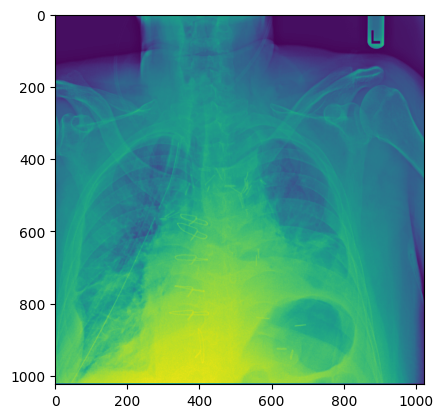

In [482]:
plt.imshow(img)

In [484]:
img.shape

(1024, 1024)

In [114]:
import torchvision
import math 
def create_retinanet(num_classes):
    model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained = True)

    num_anchors = model.head.classification_head.num_anchors

    model.head.classification_head.num_classes = num_classes

    cls_logits = torch.nn.Conv2d(256, num_anchors * num_classes, kernel_size = 3, stride = 1, padding = 1)
    torch.nn.init.normal_(cls_logits.weight, std = 0.01)
    torch.nn.init.constant_(cls_logits.bias, -math.log((1 - 0.01) / 0.01))
    model.head.classification_head.cls_logits = cls_logits

    for p in model.parameters():
        p.requires_grad = False

    for p in model.head.classification_head.parameters():
        p.requires_grad = True

    for p in model.head.regression_head.parameters():
        p.requires_grad = True

    return model

In [115]:
retina_model = create_retinanet(8)

/srv/anaconda3/envs/tagging/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/srv/anaconda3/envs/tagging/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [116]:
output = next(iter(trainloader))
img, annot = output[0], output[1]
result = retina_model(img, annot)

IndexError: tensors used as indices must be long, int, byte or bool tensors

In [110]:
annot

({'boxex': tensor([[ 63.9323, 288.2370, 216.1778, 358.1291]]),
  'labels': tensor([3.]),
  'img_size': tensor([512, 512]),
  'img_scale': tensor([1.])},)

In [ ]:
0 - Aortic enlargement
1 - Atelectasis +
2 - Calcification
3 - Cardiomegaly
4 - Consolidation
5 - ILD
6 - Infiltration
7 - Lung Opacity
8 - Nodule/Mass
9 - Other lesion
10 - Pleural effusion
11 - Pleural thickening
12 - Pneumothorax
13 - Pulmonary fibrosis

In [ ]:
Finding Label
Atelectasis     180 + 
Effusion        153 +
Cardiomegaly    146 + 
Infiltrate      123 +
Pneumonia       120
Pneumothorax     98 + 
Mass             85 + 
Nodule           79 +

In [ ]:
!kaggle datasets download -d /data1/vinbigdata-512-image-dataset

In [621]:
vin = pd.read_csv("/data1/xray_data/vinbig/vinbigdata/train.csv")

In [622]:
vin

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072
...,...,...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN,2444,3200
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN,1994,2430
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN,2048,2500
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0,1968,2040


In [623]:
classes = ["Atelectasis", "Pneumothorax", "Cardiomegaly", "Pleural effusion", "Infiltration", "Nodule/Mass" ]

mask = vin.class_name.isin(classes)

In [624]:
vin_df = vin[mask]

In [625]:
vin_df.sample(100)

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
53699,dfb91e05ce090dbd08177c0b4531dae3,Cardiomegaly,3,R10,623.0,1341.0,1584.0,1652.0,1920,2192
2329,7b41dadbe305cc9f4f6068d473f73daf,Cardiomegaly,3,R8,816.0,1630.0,1790.0,2023.0,2304,2880
65082,a9ab4843564feecfc052a300af02cf71,Cardiomegaly,3,R8,676.0,1156.0,1539.0,1450.0,1896,1976
8773,83b7785191c812c71f06b948e5843515,Cardiomegaly,3,R8,984.0,1789.0,2162.0,2228.0,2651,2738
65753,69972b49aac9f4aea137e51984cf8691,Nodule/Mass,8,R9,1381.0,1009.0,1695.0,1371.0,2304,2880
...,...,...,...,...,...,...,...,...,...,...
55512,3bb06e20b2595be65d7a95e948b2169c,Nodule/Mass,8,R10,2226.0,1323.0,2731.0,1864.0,3320,3408
29604,764eeaca1e91f7410e68f3daf40de6ab,Infiltration,6,R10,1730.0,606.0,2162.0,1313.0,2304,2880
2316,f9004576db9e423ddce7bc64608e2aed,Atelectasis,1,R10,1585.0,620.0,2169.0,936.0,2668,2840
19655,af793b61efb4ac8fba4bc62475506e23,Pleural effusion,10,R10,162.0,2779.0,303.0,2906.0,2742,3408


In [571]:
X_train = pd.read_csv("dataset/train_df.csv")

In [573]:
X_train[["Finding Label", "label"]].sample(100)

,Finding Label,label
665,Effusion,2
50,Cardiomegaly,1
416,Atelectasis,0
180,Atelectasis,0
99,Nodule/Mass,4
...,...,...
466,Pneumonia,5
20,Effusion,2
599,Cardiomegaly,1
32,Atelectasis,0


In [ ]:
Atelectasis: 0
Cardiomegaly: 1
Nodule/Mass: 4
Infiltrate : 3
Pheumonia: 5
Effusion: 2
Pneumothorax: 6


In [626]:
vin_df.loc[vin_df["class_name"] == "Cardiomegaly", "class_id"] = 1
vin_df.loc[vin_df["class_name"] == "Atelectasis", "class_id"] = 0
vin_df.loc[vin_df["class_name"] == "Infiltration", "class_id"] = 3
vin_df.loc[vin_df["class_name"] == "Nodule/Mass", "class_id"] = 4
vin_df.loc[vin_df["class_name"] == "Pleural effusion", "class_id"] = 2
vin_df.loc[vin_df["class_name"] == "Pneumothorax", "class_id"] = 6


In [627]:
vin_df[vin_df["class_name"] == "Nodule/Mass"]

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
7,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,4,R9,557.0,2352.0,675.0,2484.0,2568,3353
40,8e063eadea9a6aeb684c893c8598be3e,Nodule/Mass,4,R10,376.0,1867.0,438.0,1914.0,2836,3180
56,d106ec9b305178f3da060efe3191499a,Nodule/Mass,4,R8,796.0,1078.0,850.0,1129.0,2896,3264
59,f32ab457c492c30221d3a89fe7c6b25a,Nodule/Mass,4,R15,1202.0,1090.0,1590.0,1654.0,2940,3000
66,a3f5ac68c8d1b1805be21f18c47fc186,Nodule/Mass,4,R9,2123.0,922.0,2233.0,1010.0,2842,3072
...,...,...,...,...,...,...,...,...,...,...
67717,9943805f08872ab64d994fc84ff1b25d,Nodule/Mass,4,R10,374.0,1085.0,479.0,1204.0,1936,2280
67735,c008cfaf7009c94d297cc2e715e81c03,Nodule/Mass,4,R10,1927.0,948.0,2088.0,1126.0,2544,3008
67834,0162dad8330007f8f0daf43bcf4033f1,Nodule/Mass,4,R10,940.0,543.0,971.0,562.0,3072,3072
67863,88bf02cc510da5050a869c290d8f8565,Nodule/Mass,4,R9,944.0,795.0,1090.0,1002.0,2304,2880


In [628]:
IMG_SIZE = 512
vin_df['x_min'] = (vin_df['x_min']/vin_df['width'])*IMG_SIZE
vin_df['y_min'] = (vin_df['y_min']/vin_df['height'])*IMG_SIZE
vin_df['x_max'] = (vin_df['x_max']/vin_df['width'])*IMG_SIZE
vin_df['y_max'] = (vin_df['y_max']/vin_df['height'])*IMG_SIZE

/tmp/ipykernel_1653336/746457688.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vin_df['x_min'] = (vin_df['x_min']/vin_df['width'])*IMG_SIZE
/tmp/ipykernel_1653336/746457688.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vin_df['y_min'] = (vin_df['y_min']/vin_df['height'])*IMG_SIZE
/tmp/ipykernel_1653336/746457688.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [629]:
vin_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,1,R10,170.092308,301.369863,406.892308,401.315068,2080,2336
7,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,4,R9,111.052960,359.148225,134.579439,379.304503,2568,3353
17,80caa435b6ab5edaff4a0a758ffaec6e,Atelectasis,0,R9,56.471843,76.132604,236.123959,389.726424,3001,3107
20,0622cd29e4e0e4f198abf15614819ae8,Cardiomegaly,1,R10,215.622428,302.336574,433.310206,377.394166,2479,2674
37,d7aea6f37597df566725da73655edcc2,Infiltration,3,R8,348.965305,171.470987,463.050116,304.636230,2594,3395
...,...,...,...,...,...,...,...,...,...,...
67874,157f5f6e3b028ef503ff946b28afaa92,Cardiomegaly,1,R10,114.888889,331.555556,399.555556,406.577778,2304,2880
67886,6a0da094696816e8ccc92c81602173d1,Pleural effusion,2,R8,42.581673,281.696970,226.422311,376.242424,2008,2112
67893,66332eb5425bcdc6854aae970cc656b9,Nodule/Mass,4,R8,376.850136,276.476544,402.485014,303.778603,2936,2963
67903,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,2,R9,53.333333,275.555556,124.888889,355.733333,2304,2880


In [630]:
from sklearn.model_selection import train_test_split

vin_df_y = vin_df.class_name
X_train, X_test, y_train, y_test = train_test_split(vin_df, vin_df_y, test_size = 0.15,  stratify=vin_df_y)

In [771]:
X_train

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
26983,0452d38f45e4e79f91821e88bb812608,Cardiomegaly,1,R9,219.319970,302.793256,424.195991,379.797693,2694,2254
38725,1e584da1fcf0c0297a22f0e36ce86732,Nodule/Mass,4,R9,149.858538,146.017710,170.866745,161.025954,2559,3275
26617,9b294ef55b60d28d047089d91a1ca502,Cardiomegaly,1,R8,187.503737,297.586498,419.970105,362.756681,2676,2844
2489,03e6ecfa6f6fb33dfeac6ca4f9b459c9,Nodule/Mass,4,R8,412.956772,272.427807,430.847262,289.197861,2776,2992
7819,ce2c5376b597eb067395da4c7f9960aa,Infiltration,3,R8,80.478483,113.967914,210.252371,319.657754,2742,2992
...,...,...,...,...,...,...,...,...,...,...
60907,659c6031ed4b7d875e5e14662eb50bf2,Cardiomegaly,1,R10,198.968481,273.882353,408.573066,366.117647,2792,3264
30090,0cb91b8fe14a6d51725371b1956750a0,Cardiomegaly,1,R9,168.879581,301.018787,396.924458,361.569449,2674,3247
64299,3fe37d132711f84805405defb3673681,Cardiomegaly,1,R9,206.054902,295.404959,438.713725,378.446281,2040,1936
49445,7478eac70ba86cb5e7e7a29a9acbd6e0,Cardiomegaly,1,R8,183.500000,237.000000,362.833333,297.500000,3072,3072


In [632]:
X_test.to_csv("dataset/vin_val_df.csv")
X_train.to_csv("dataset/vin_train_df.csv")

In [633]:
class VinXrayDataset(Dataset):
    def __init__(self, root, annotations_file, transforms=None):
        self.root = root
        self.transforms = transforms
        self.annotations_df = pd.read_csv(annotations_file, index_col=[0])

    def __len__(self):
        return len(self.annotations_df)

    def __getitem__(self, idx):
        row = self.annotations_df.iloc[idx]
        image_id = row['image_id']
        image_file_name = image_id + ".png"
        img_path = os.path.join(self.root, image_file_name)
        image = read_rgb(img_path)
        # to pascal vos format
        box = [
            row['x_min'],
            row['y_min'],
            row['x_max'],
            row['y_max'],
        ]
        
        label = row['class_id']
        box = np.array(box)

        if self.transforms:
            transformed = self.transforms(image=image, bboxes=[box], labels=[label])
            image = transformed['image']
            _, img_h, img_w = image.shape
            bboxes = transformed['bboxes']
            labels = transformed['labels']
            target = {
                'bbox': torch.as_tensor(bboxes, dtype=torch.float32),
                'cls': torch.as_tensor(labels, dtype=torch.float32),
                'img_size': torch.tensor([img_h, img_w]),
                'img_scale': torch.tensor([1.0]),
            }

        return image / 255. , target
    

In [634]:
image_folder_path = "/data1/xray_data/vinbig/vinbigdata/train"
annotations_file = 'dataset/vin_val_df.csv'
train_dataset = VinXrayDataset(image_folder_path, annotations_file, transforms=get_val_transforms())
trainloader = DataLoader(train_dataset, batch_size = 1)#, collate_fn=alex_fn)

In [635]:
train_dataset[0]

(tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.5725, 0.0078],
          [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0078],
          [0.0039, 0.0078, 0.0078,  ..., 0.0000, 0.0000, 0.0078],
          ...,
          [0.1961, 0.2118, 0.2235,  ..., 0.1333, 0.1294, 0.1098],
          [0.1961, 0.2157, 0.2235,  ..., 0.1333, 0.1176, 0.0980],
          [0.0627, 0.2118, 0.2275,  ..., 0.1294, 0.1098, 0.0863]],
 
         [[0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.5725, 0.0078],
          [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0078],
          [0.0039, 0.0078, 0.0078,  ..., 0.0000, 0.0000, 0.0078],
          ...,
          [0.1961, 0.2118, 0.2235,  ..., 0.1333, 0.1294, 0.1098],
          [0.1961, 0.2157, 0.2235,  ..., 0.1333, 0.1176, 0.0980],
          [0.0627, 0.2118, 0.2275,  ..., 0.1294, 0.1098, 0.0863]],
 
         [[0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.5725, 0.0078],
          [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0078],
          [0.0039, 0.0078, 0.0078,  ...,

In [636]:
def visualize_labels(n, label_idx):
    fig, axs = plt.subplots(1, n, figsize=(15, 15))

    labels = vin_df["class_name"].unique()
    label = labels[label_idx]
    df_filtered = vin_df[vin_df['class_name'] == label]

    random_indices = np.random.choice(len(df_filtered), n, replace=False)

    for i, index in enumerate(random_indices):
        image_name = df_filtered.iloc[index, 0]+".png"
        x, y, w, h = df_filtered.iloc[index, 4], df_filtered.iloc[index, 5], df_filtered.iloc[index, 6], df_filtered.iloc[index, 7]

        image = cv2.imread(os.path.join(image_folder_path, image_name))
        cv2.rectangle(image, (int(x), int(y)), (int(w), int(h)), (255, 0, 0), 2)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        axs[i].imshow(image_rgb)
        axs[i].set_title(f'Label: {label}')
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

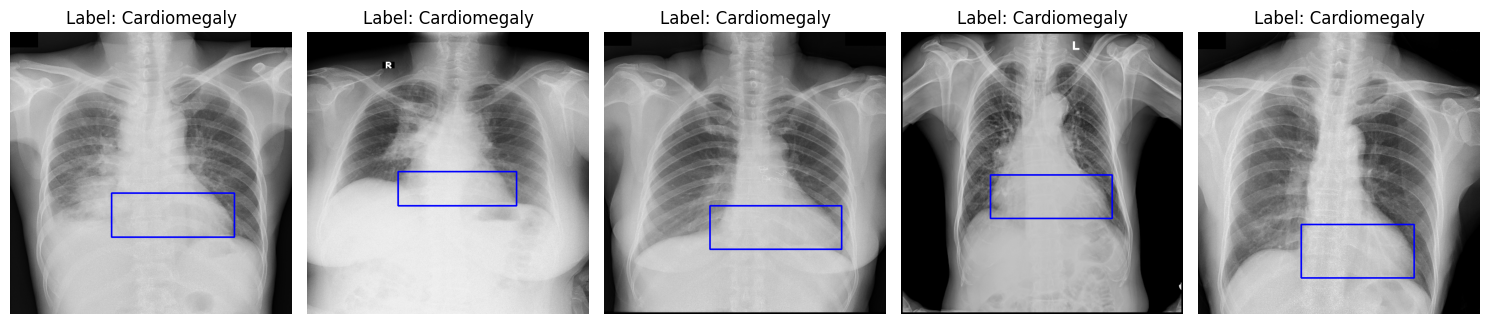

In [650]:
visualize_labels(5, 0)

<Axes: xlabel='class_name'>

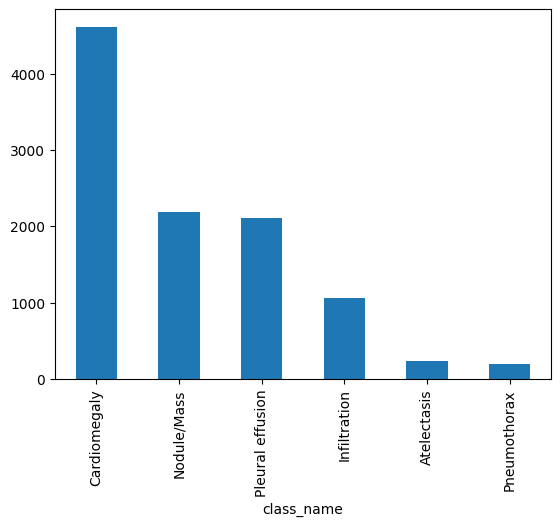

In [773]:
X_train["class_name"].value_counts().plot(kind='bar')